In [1]:
import pandas as pd
import numpy as np
import pickle
from utils import *
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, log_loss
from sklearn.model_selection import StratifiedKFold, cross_validate
from slice_finder import SliceFinder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_shop = pd.read_csv(
    "sets/online_shoppers/online_shoppers_intention.csv",
        names=["Administrative", "Administrative_Duration", "Informational", "Informational_Duration", "ProductRelated",
            "ProductRelated_Duration", "BounceRates", "ExitRates", "PageValues", "SpecialDay", "Month", "OperatingSystems",
            "Browser", "Region", "TrafficType", "VisitorType", "Weekend", "Target"],
                sep=r'\s*,\s*',
                engine='python',
                na_values="?")

df_shop = df_shop.dropna()

# Encode categorical features
encoders = {}
for column in df_shop.columns:
    if df_shop.dtypes[column] == np.object_:
        le = LabelEncoder()
        df_shop[column] = le.fit_transform(df_shop[column])
        encoders[column] = le
        print(column, le.classes_, le.transform(le.classes_))

X, y = df_shop[df_shop.columns.difference(["Target"])], df_shop["Target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Month ['Aug' 'Dec' 'Feb' 'Jul' 'June' 'Mar' 'May' 'Nov' 'Oct' 'Sep'] [0 1 2 3 4 5 6 7 8 9]
VisitorType ['New_Visitor' 'Other' 'Returning_Visitor'] [0 1 2]


In [ ]:
lr = RandomForestClassifier(max_depth=5, n_estimators=10)
lr.fit(X_train, y_train)

sf = SliceFinder(lr, (X_train, y_train))
metrics_all = sf.evaluate_model((X_train,y_train))
reference = (np.mean(metrics_all), np.std(metrics_all), len(metrics_all))

In [ ]:
name = 'Shop.p'
recommendations = sf.find_slice(k=100, epsilon=0.4, degree=2, max_workers=4, name=name)

for s in recommendations:
    print ('\n=====================\nSlice description:')
    for k, v in list(s.filters.items()):
        values = ''
        if k in encoders:
            le = encoders[k]
            for v_ in v:
                values += '%s '%(le.inverse_transform(v_)[0])
        else:
            for v_ in sorted(v, key=lambda x: x[0]):
                if len(v_) > 1:
                    values += '%s ~ %s'%(v_[0], v_[1])
                else:
                    values += '%s '%(v_[0])
        print ('%s:%s'%(k, values))
    print ('---------------------\neffect_size: %s'%(s.effect_size))
    print ('---------------------\nmetric: %s'%(s.metric))
    print ('size: %s'%(s.size))

In [ ]:
with open('./Slices/Shop.p', 'rb') as file:
    data = pickle.load(file)
    
    data = sorted(data, key=lambda d: d.size, reverse=True)
    for d in data:
        print(f'Description of the region:  {d.filters}')
        print(f'Region instances: {d.data_idx}')
        print(f'Region size:    {d.size}')
        print(f'Efect size: {d.effect_size}')
        print(f'Log Loss:    {d.metric}')
        print('\n')

In [ ]:
shop_train = pd.concat([X_train, y_train], axis=1)
shop_train.groupby('Target').describe()

In [3]:
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

start_time_model = time.time()
rf_optimized = model_train(X_train, y_train)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_train, y_train, cv=skf, scoring=scoring)

rf_optimized.fit(X_train, y_train)

y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

print("Size of dataset:", len(X_train))
print("Time to train the model:", execution_time_model, "s")

print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))


Size of dataset: 9864
Time to train the model: 233.17451667785645 s

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.90 (+/- 0.01)
Recall: 0.57 (+/- 0.03)
F1 Score: 0.65 (+/- 0.03)
Log-loss: 0.23 (+/- 0.01)

Results on the validation set:
Accuracy: 0.90
Log-loss: 0.24

Classification report on the validation set:
              precision    recall  f1-score   support

       False       0.92      0.97      0.94      2084
        True       0.76      0.55      0.64       382

    accuracy                           0.90      2466
   macro avg       0.84      0.76      0.79      2466
weighted avg       0.90      0.90      0.90      2466



In [ ]:
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

smote = SMOTE(sampling_strategy='auto', random_state=42)

y_slice = y_train
X_slice = X_train

X_slice_smote, y_slice_smote = smote.fit_resample(X_slice, y_slice)
region_SMOTE = (pd.concat([pd.DataFrame(X_slice_smote, columns=X_slice.columns), pd.Series(y_slice_smote, name='Target')], axis=1))

y_SMOTE_data = region_SMOTE['Target']
X_SMOTE_data = region_SMOTE.drop(columns='Target')

start_time_model = time.time()
rf_optimized = model_train(X_SMOTE_data, y_SMOTE_data)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_SMOTE_data, y_SMOTE_data, cv=skf, scoring=scoring)

rf_optimized.fit(X_SMOTE_data, y_SMOTE_data)

y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

print("Size of dataset:", len(X_train))
print("Size of new dataset:", len(X_SMOTE_data))
print("Time to train the model:", execution_time_model, "s")

print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

In [ ]:
shop_train = pd.concat([X_train, y_train], axis=1)
region = shop_train.query('Administrative==13')
region.groupby('Target').describe()

In [ ]:
# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region
region = 'Administrative==13' 

# Apply SMOTE in the region of interest
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_region = X_train.query(region)  # Select only samples from the region
y_region = y_train[X_region.index]

# Apply SMOTE to the selected region
X_region_smote, y_region_smote = smote.fit_resample(X_region, y_region)

# Combine the original dataset with the balanced one to form the new training set
X_SMOTE_data = pd.concat([X_train.drop(X_region.index), pd.DataFrame(X_region_smote, columns=X_train.columns)])
y_SMOTE_data = pd.concat([y_train.drop(X_region.index), pd.Series(y_region_smote)])

start_time_model = time.time()
rf_optimized = model_train(X_SMOTE_data, y_SMOTE_data)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_SMOTE_data, y_SMOTE_data, cv=skf, scoring=scoring)

rf_optimized.fit(X_SMOTE_data, y_SMOTE_data)

y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Size of dataset:", len(X_train))
print("Size of the new dataset:", len(X_SMOTE_data))
print("Time to train the model:", execution_time_model, "seconds")

# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

In [ ]:
shop_train = pd.concat([X_train, y_train], axis=1)
region = shop_train.query('ProductRelated==58')
region.groupby('Target').describe()

In [ ]:
# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region
region = 'ProductRelated==58' 

# Apply SMOTE in the region of interest
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_region = X_train.query(region)  # Select only samples from the region
y_region = y_train[X_region.index]

# Apply SMOTE to the selected region
X_region_smote, y_region_smote = smote.fit_resample(X_region, y_region)

# Combine the original dataset with the balanced one to form the new training set
X_SMOTE_data = pd.concat([X_train.drop(X_region.index), pd.DataFrame(X_region_smote, columns=X_train.columns)])
y_SMOTE_data = pd.concat([y_train.drop(X_region.index), pd.Series(y_region_smote)])

start_time_model = time.time()
rf_optimized = model_train(X_SMOTE_data, y_SMOTE_data)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_SMOTE_data, y_SMOTE_data, cv=skf, scoring=scoring)

rf_optimized.fit(X_SMOTE_data, y_SMOTE_data)

y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Size of dataset:", len(X_train))
print("Size of the new dataset:", len(X_SMOTE_data))
print("Time to train the model:", execution_time_model, "seconds")

# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

In [ ]:
shop_train = pd.concat([X_train, y_train], axis=1)
region = shop_train.query('ProductRelated==64')
region.groupby('Target').describe()

In [ ]:
# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region
region = 'ProductRelated==64'

# Apply SMOTE in the region of interest
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_region = X_train.query(region)  # Select only samples from the region
y_region = y_train[X_region.index]

# Apply SMOTE to the selected region
X_region_smote, y_region_smote = smote.fit_resample(X_region, y_region)

# Combine the original dataset with the balanced one to form the new training set
X_SMOTE_data = pd.concat([X_train.drop(X_region.index), pd.DataFrame(X_region_smote, columns=X_train.columns)])
y_SMOTE_data = pd.concat([y_train.drop(X_region.index), pd.Series(y_region_smote)])

start_time_model = time.time()
rf_optimized = model_train(X_SMOTE_data, y_SMOTE_data)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_SMOTE_data, y_SMOTE_data, cv=skf, scoring=scoring)

rf_optimized.fit(X_SMOTE_data, y_SMOTE_data)

y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Size of dataset:", len(X_train))
print("Size of the new dataset:", len(X_SMOTE_data))
print("Time to train the model:", execution_time_model, "seconds")

# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

# Case Study

In [3]:
with open('Slices/Shop.p', 'rb') as file:
    data = pickle.load(file)
    
    name = []
    aux_1 = []
    aux_2 = []
    
    data = sorted(data, key=lambda d: d.size, reverse=True)
    for d in data:
        print ('\n=====================\nSlice description:')
        for k, v in list(d.filters.items()):
            values = ''
            if k in encoders:
                le = encoders[k]
                for v_ in v:
                    values += '%s '%(le.inverse_transform(v_)[0])
            else:
                for v_ in sorted(v, key=lambda x: x[0]):
                    if len(v_) > 1:
                        values += '%s ~ %s'%(v_[0], v_[1])
                    else:
                        values += '%s '%(v_[0])
            print ('%s:%s'%(k, values))
        #print(f'Description of the region:  {d.filters}')
        print(f'Region instances: {d.data_idx}')
        print(f'Region size:    {d.size}')
        print(f'Efect size: {d.effect_size}')
        print(f'Log Loss:    {d.metric}')
        print('\n')
        
        if d.size > 10:
            aux_1.append(d.size)
            aux_2.append(d.effect_size)


Slice description:
Administrative:13 
Region instances: Index([  478,  6770,  7240,  7036,  6454,  9780,  6941,  8816,  6942,  1989,
       10709,  6791,  9223,  2045,  2031, 11693,  7762, 11256,  9022,  6820,
        5998,  2967,  8496,  9147,  9755,  4700,  7871,  9845, 11068, 10833,
        9332,  7362,  5497,  4115,  6969,   282,  6992,  5526,  9733,  4443,
        8901,  9558,  4515,   619,  7290,  5009, 11965,  6647,  4027],
      dtype='int64')
Region size:    49
Efect size: 0.49093451913137004
Log Loss:    0.550750929190253



Slice description:
ProductRelated:58 
Region instances: Index([ 9981,  9987, 10150,  9109, 10889,  7731, 10212, 11185, 11242,   629,
        7890,  8631,  4381,  3321,  8953, 10944,  4601,  2110,  8343,  4705,
        2696,  7035, 11255, 10360,   683,  8778,  3271,  4559,  3197,  4446,
        5623,  7670,  9821,  5339,  8020,  3084],
      dtype='int64')
Region size:    36
Efect size: 0.5605759755761787
Log Loss:    0.6789157413904122



Slice descripti

In [4]:
import json
from collections import Counter

def convert_types(obj):
    if isinstance(obj, dict):
        return {k: convert_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_types(i) for i in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_types(i) for i in obj)
    elif hasattr(obj, 'item'): 
        return obj.item()
    else:
        return obj

dicionario = {}

for d in data:
    if d.size > 1:
        filters_clean = convert_types(d.filters)
        filters_str = json.dumps(filters_clean, sort_keys=True)
        dicionario[filters_str] = []
        for i in d.data_idx:
            dicionario[filters_str].append(i)

feature_cont = Counter()

for feature in dicionario.keys():
    key_dict = json.loads(feature)
    for feature in key_dict.keys():
        feature_cont[feature] += 1

print(feature_cont)

Counter({'Administrative_Duration': 89, 'ExitRates': 87, 'BounceRates': 73, 'Informational_Duration': 61, 'ProductRelated': 52, 'Administrative': 5, 'PageValues': 5, 'Informational': 3, 'Browser': 1, 'TrafficType': 1})


In [5]:
shop_train = pd.concat([X_train, y_train], axis=1)

shop_train.groupby('Administrative_Duration').describe()

Administrative                                         \
                                 count       mean       std   min   25%   50%   
Administrative_Duration                                                         
0.000000                        4706.0   0.021887  0.152029   0.0   0.0   0.0   
1.333333                           1.0   1.000000       NaN   1.0   1.0   1.0   
2.000000                          14.0   1.142857  0.363137   1.0   1.0   1.0   
3.000000                          19.0   1.000000  0.000000   1.0   1.0   1.0   
3.500000                           2.0   1.000000  0.000000   1.0   1.0   1.0   
...                                ...        ...       ...   ...   ...   ...   
2156.166667                        1.0   5.000000       NaN   5.0   5.0   5.0   
2629.253968                        1.0  17.000000       NaN  17.0  17.0  17.0   
2657.318056                        1.0  15.000000       NaN  15.0  15.0  15.0   
2720.500000                        1.0   7.000000       NaN   7.0   7.0   7.0   
3398.750000                        1.0   5.000000       NaN   5.0   5.0   5.0   

                                    BounceRates            ... TrafficType  \
                          75%   max       count      mean  ...         75%   
Administrative_Duration                                    ...               
0.000000                  0.0   2.0      4706.0  0.039287  ...         4.0   
1.333333                  1.0   1.0         1.0  0.006061  ...         2.0   
2.000000                  1.0   2.0        14.0  0.021295  ...         7.0   
3.000000                  1.0   1.0        19.0  0.003548  ...         3.5   
3.500000                  1.0   1.0         2.0  0.000000  ...         2.0   
...                       ...   ...         ...       ...  ...         ...   
2156.166667               5.0   5.0         1.0  0.036364  ...         4.0   
2629.253968              17.0  17.0         1.0  0.004851  ...        14.0   
2657.318056              15.0  15.0         1.0  0.005316  ...         2.0   
2720.500000               7.0   7.0         1.0  0.032237  ...        13.0   
3398.750000               5.0   5.0         1.0  0.000764  ...         2.0   

                              VisitorType                                     \
                          max       count      mean       std  min  25%  50%   
Administrative_Duration                                                        
0.000000                 20.0      4706.0  1.819167  0.564842  0.0  2.0  2.0   
1.333333                  2.0         1.0  2.000000       NaN  2.0  2.0  2.0   
2.000000                 20.0        14.0  2.000000  0.000000  2.0  2.0  2.0   
3.000000                 10.0        19.0  1.526316  0.841191  0.0  1.5  2.0   
3.500000                  2.0         2.0  2.000000  0.000000  2.0  2.0  2.0   
...                       ...         ...       ...       ...  ...  ...  ...   
2156.166667               4.0         1.0  2.000000       NaN  2.0  2.0  2.0   
2629.253968              14.0         1.0  2.000000       NaN  2.0  2.0  2.0   
2657.318056               2.0         1.0  2.000000       NaN  2.0  2.0  2.0   
2720.500000              13.0         1.0  2.000000       NaN  2.0  2.0  2.0   
3398.750000               2.0         1.0  2.000000       NaN  2.0  2.0  2.0   

                                   
                         75%  max  
Administrative_Duration            
0.000000                 2.0  2.0  
1.333333                 2.0  2.0  
2.000000                 2.0  2.0  
3.000000                 2.0  2.0  
3.500000                 2.0  2.0  
...                      ...  ...  
2156.166667              2.0  2.0  
2629.253968              2.0  2.0  
2657.318056              2.0  2.0  
2720.500000              2.0  2.0  
3398.750000              2.0  2.0  

[2821 rows x 120 columns]

<Axes: xlabel='Administrative_Duration', ylabel='Count'>

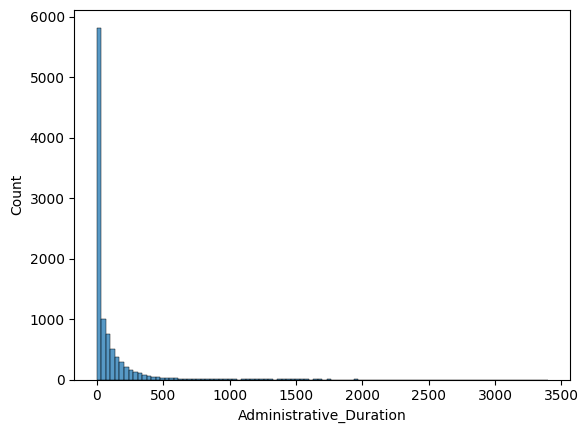

In [6]:
import seaborn as sns

sns.histplot(shop_train['Administrative_Duration'], bins=100)

In [ ]:
shop_train.groupby('ExitRates').describe()

Administrative                                               \
                   count      mean       std  min  25%  50%  75%  max   
ExitRates                                                               
0.000000            61.0  1.114754  1.603105  0.0  0.0  0.0  2.0  7.0   
0.000176             1.0  6.000000       NaN  6.0  6.0  6.0  6.0  6.0   
0.000250             1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0   
0.000263             1.0  5.000000       NaN  5.0  5.0  5.0  5.0  5.0   
0.000292             1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0   
...                  ...       ...       ...  ...  ...  ...  ...  ...   
0.183333             2.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
0.186667             3.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
0.188889             1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0   
0.192308             1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0   
0.200000           578.0  0.015571  0.137191  0.0  0.0  0.0  0.0  2.0   

          Administrative_Duration               ... TrafficType        \
                            count         mean  ...         75%   max   
ExitRates                                       ...                     
0.000000                     61.0    41.121858  ...         4.0  20.0   
0.000176                      1.0   615.250000  ...         1.0   1.0   
0.000250                      1.0  1566.600000  ...         2.0   2.0   
0.000263                      1.0   131.995614  ...         3.0   3.0   
0.000292                      1.0    33.000000  ...         3.0   3.0   
...                           ...          ...  ...         ...   ...   
0.183333                      2.0     0.000000  ...        10.0  13.0   
0.186667                      3.0     0.000000  ...        11.5  20.0   
0.188889                      1.0     0.000000  ...         2.0   2.0   
0.192308                      1.0     0.000000  ...        13.0  13.0   
0.200000                    578.0     0.000000  ...         6.0  20.0   

          VisitorType                                               
                count      mean       std  min  25%  50%  75%  max  
ExitRates                                                           
0.000000         61.0  1.049180  1.007079  0.0  0.0  2.0  2.0  2.0  
0.000176          1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0  
0.000250          1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0  
0.000263          1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0  
0.000292          1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0  
...               ...       ...       ...  ...  ...  ...  ...  ...  
0.183333          2.0  2.000000  0.000000  2.0  2.0  2.0  2.0  2.0  
0.186667          3.0  2.000000  0.000000  2.0  2.0  2.0  2.0  2.0  
0.188889          1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0  
0.192308          1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0  
0.200000        578.0  1.897924  0.409966  0.0  2.0  2.0  2.0  2.0  

[3971 rows x 120 columns]

<Axes: xlabel='ExitRates', ylabel='Count'>

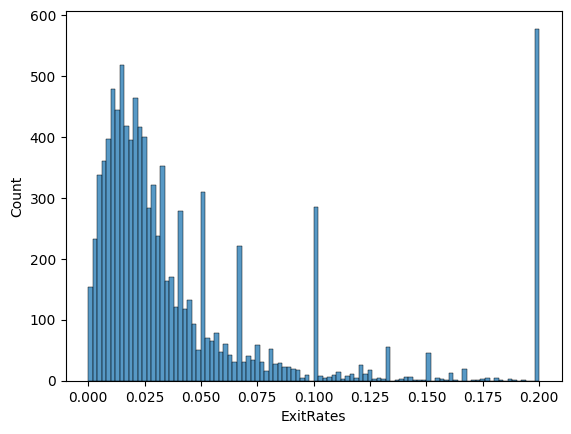

In [8]:
sns.histplot(shop_train['ExitRates'], bins=100)

In [9]:
shop_train.groupby('BounceRates').describe()

Administrative                                                     \
                     count       mean       std   min   25%   50%   75%   max   
BounceRates                                                                     
0.000000            4423.0   2.056749  2.792085   0.0   0.0   1.0   3.0  24.0   
0.000073               1.0  13.000000       NaN  13.0  13.0  13.0  13.0  13.0   
0.000075               1.0  14.000000       NaN  14.0  14.0  14.0  14.0  14.0   
0.000081               1.0   6.000000       NaN   6.0   6.0   6.0   6.0   6.0   
0.000081               1.0   5.000000       NaN   5.0   5.0   5.0   5.0   5.0   
...                    ...        ...       ...   ...   ...   ...   ...   ...   
0.166667               3.0   0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   
0.175000               1.0   0.000000       NaN   0.0   0.0   0.0   0.0   0.0   
0.176923               1.0   0.000000       NaN   0.0   0.0   0.0   0.0   0.0   
0.180000               3.0   0.000000  0.000000   0.0   0.0   0.0   0.0   0.0   
0.200000             570.0   0.015789  0.138139   0.0   0.0   0.0   0.0   2.0   

            Administrative_Duration              ... TrafficType        \
                              count        mean  ...         75%   max   
BounceRates                                      ...                     
0.000000                     4423.0   73.902377  ...         4.0  20.0   
0.000073                        1.0  278.151961  ...         1.0   1.0   
0.000075                        1.0  367.250000  ...         1.0   1.0   
0.000081                        1.0   72.019608  ...         2.0   2.0   
0.000081                        1.0  100.916667  ...         2.0   2.0   
...                             ...         ...  ...         ...   ...   
0.166667                        3.0    0.000000  ...        11.5  13.0   
0.175000                        1.0    0.000000  ...        13.0  13.0   
0.176923                        1.0    0.000000  ...        13.0  13.0   
0.180000                        3.0    0.000000  ...        11.0  20.0   
0.200000                      570.0    0.000000  ...         6.0  20.0   

            VisitorType                                               
                  count      mean       std  min  25%  50%  75%  max  
BounceRates                                                           
0.000000         4423.0  1.459191  0.881026  0.0  0.0  2.0  2.0  2.0  
0.000073            1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0  
0.000075            1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0  
0.000081            1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0  
0.000081            1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0  
...                 ...       ...       ...  ...  ...  ...  ...  ...  
0.166667            3.0  2.000000  0.000000  2.0  2.0  2.0  2.0  2.0  
0.175000            1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0  
0.176923            1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0  
0.180000            3.0  2.000000  0.000000  2.0  2.0  2.0  2.0  2.0  
0.200000          570.0  1.900000  0.404934  0.0  2.0  2.0  2.0  2.0  

[1596 rows x 120 columns]

<Axes: xlabel='BounceRates', ylabel='Count'>

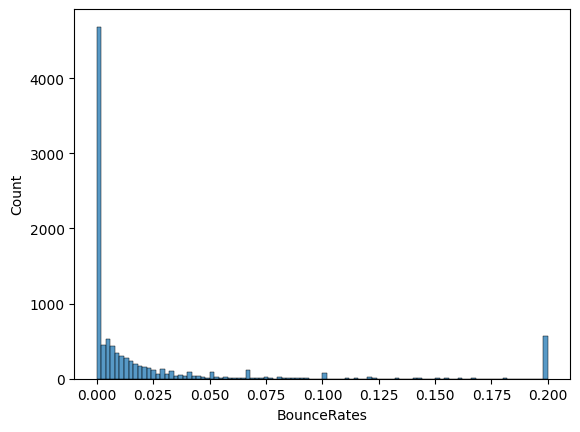

In [10]:
sns.histplot(shop_train['BounceRates'], bins=100)

In [ ]:
shop_train.groupby('Informational_Duration').describe()

Administrative                                      \
                                count      mean       std  min   25%  50%   
Informational_Duration                                                      
0.000000                       7938.0  1.713530  2.679244  0.0  0.00  0.0   
1.000000                          3.0  2.666667  3.055050  0.0  1.00  2.0   
1.500000                          1.0  0.000000       NaN  0.0  0.00  0.0   
2.000000                         10.0  2.600000  2.756810  0.0  0.25  1.5   
2.500000                          1.0  0.000000       NaN  0.0  0.00  0.0   
...                               ...       ...       ...  ...   ...  ...   
2166.500000                       1.0  8.000000       NaN  8.0  8.00  8.0   
2195.300000                       1.0  3.000000       NaN  3.0  3.00  3.0   
2252.033333                       1.0  8.000000       NaN  8.0  8.00  8.0   
2256.916667                       1.0  4.000000       NaN  4.0  4.00  4.0   
2549.375000                       1.0  5.000000       NaN  5.0  5.00  5.0   

                                   Administrative_Duration               ...  \
                         75%   max                   count         mean  ...   
Informational_Duration                                                   ...   
0.000000                3.00  23.0                  7938.0    58.641309  ...   
1.000000                4.00   6.0                     3.0   124.000000  ...   
1.500000                0.00   0.0                     1.0     0.000000  ...   
2.000000                5.25   7.0                    10.0    64.342917  ...   
2.500000                0.00   0.0                     1.0     0.000000  ...   
...                      ...   ...                     ...          ...  ...   
2166.500000             8.00   8.0                     1.0   145.100000  ...   
2195.300000             3.00   3.0                     1.0    28.800000  ...   
2252.033333             8.00   8.0                     1.0   116.972222  ...   
2256.916667             4.00   4.0                     1.0   367.000000  ...   
2549.375000             5.00   5.0                     1.0  3398.750000  ...   

                       ExitRates_binned      BounceRates_binned            \
                                    75%  max              count      mean   
Informational_Duration                                                      
0.000000                            3.0  3.0             7938.0  0.768582   
1.000000                            2.0  2.0                3.0  1.333333   
1.500000                            3.0  3.0                1.0  1.000000   
2.000000                            1.0  3.0               10.0  1.000000   
2.500000                            1.0  1.0                1.0  1.000000   
...                                 ...  ...                ...       ...   
2166.500000                         2.0  2.0                1.0  0.000000   
2195.300000                         2.0  2.0                1.0  2.000000   
2252.033333                         0.0  0.0                1.0  1.000000   
2256.916667                         2.0  2.0                1.0  0.000000   
2549.375000                         2.0  2.0                1.0  0.000000   

                                                           
                             std  min  25%  50%  75%  max  
Informational_Duration                                     
0.000000                0.859537  0.0  0.0  0.0  2.0  2.0  
1.000000                1.154701  0.0  1.0  2.0  2.0  2.0  
1.500000                     NaN  1.0  1.0  1.0  1.0  1.0  
2.000000                0.666667  0.0  1.0  1.0  1.0  2.0  
2.500000                     NaN  1.0  1.0  1.0  1.0  1.0  
...                          ...  ...  ...  ...  ...  ...  
2166.500000                  NaN  0.0  0.0  0.0  0.0  0.0  
2195.300000                  NaN  2.0  2.0  2.0  2.0  2.0  
2252.033333                  NaN  1.0  1.0  1.0  1.0  1.0  
2256.916667             

<Axes: xlabel='Informational_Duration', ylabel='Count'>

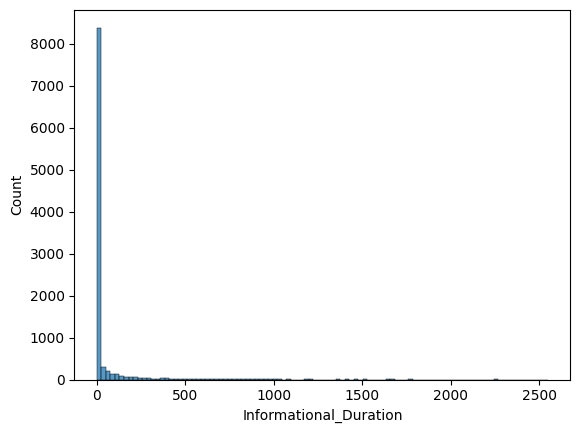

In [22]:
sns.histplot(shop_train['Informational_Duration'], bins=100)

In [23]:
shop_train.groupby('ProductRelated').describe()

Administrative                                               \
                        count       mean       std   min   25%   50%   75%   
ProductRelated                                                               
0                        27.0   0.851852  0.907393   0.0   0.0   1.0   1.5   
1                       505.0   0.095050  0.453027   0.0   0.0   0.0   0.0   
2                       377.0   0.527851  1.189446   0.0   0.0   0.0   0.0   
3                       372.0   0.822581  1.695316   0.0   0.0   0.0   1.0   
4                       320.0   0.800000  1.550811   0.0   0.0   0.0   1.0   
...                       ...        ...       ...   ...   ...   ...   ...   
501                       1.0  11.000000       NaN  11.0  11.0  11.0  11.0   
534                       1.0   9.000000       NaN   9.0   9.0   9.0   9.0   
584                       1.0  27.000000       NaN  27.0  27.0  27.0  27.0   
686                       1.0  20.000000       NaN  20.0  20.0  20.0  20.0   
705                       1.0  17.000000       NaN  17.0  17.0  17.0  17.0   

                     Administrative_Duration               ...  \
                 max                   count         mean  ...   
ProductRelated                                             ...   
0                3.0                    27.0    17.011111  ...   
1                4.0                   505.0     3.700198  ...   
2                7.0                   377.0    20.414854  ...   
3               12.0                   372.0    29.056541  ...   
4                7.0                   320.0    31.030416  ...   
...              ...                     ...          ...  ...   
501             11.0                     1.0   631.416667  ...   
534              9.0                     1.0   444.284722  ...   
584             27.0                     1.0   853.735949  ...   
686             20.0                     1.0   199.456273  ...   
705             17.0                     1.0  2629.253968  ...   

               ExitRates_binned      BounceRates_binned                      \
                            75%  max              count      mean       std   
ProductRelated                                                                
0                           3.0  3.0               27.0  1.111111  1.012739   
1                           3.0  3.0              505.0  1.746535  0.666006   
2                           3.0  3.0              377.0  0.610080  0.919183   
3                           3.0  3.0              372.0  0.733871  0.963838   
4                           3.0  3.0              320.0  0.653125  0.931000   
...                         ...  ...                ...       ...       ...   
501                         1.0  1.0                1.0  1.000000       NaN   
534                         1.0  1.0                1.0  1.000000       NaN   
584                         0.0  0.0                1.0  0.000000       NaN   
686                         1.0  1.0                1.0  1.000000       NaN   
705                         1.0  1.0                1.0  1.000000       NaN   

                                         
                min  25%  50%  75%  max  
ProductRelated                           
0               0.0  0.0  2.0  2.0  2.0  
1               0.0  2.0  2.0  2.0  2.0  
2               0.0  0.0  0.0  2.0  2.0  
3               0.0  0.0  0.0  2.0  2.0  
4               0.0  0.0  0.0  2.0  2.0  
...             ...  ...  ...  ...  ...  
501             1.0  1.0  1.0  1.0  1.0  
534             1.0  1.0  1.0  1.0  1.0  
584             0.0  0.0  0.0  0.0  0.0  
686             1.0  1.0  1.0  1.0  1.0  
705             1.0  1.0  1.0  1.0  1.0  

[284 rows x 144 columns]

<Axes: xlabel='ProductRelated', ylabel='Count'>

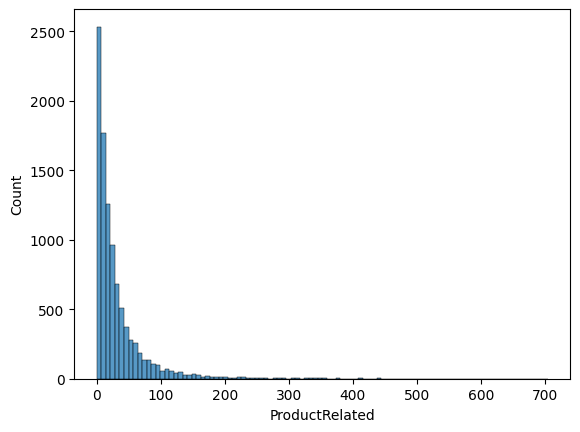

In [24]:
sns.histplot(shop_train['ProductRelated'], bins=100)

# !

In [54]:
df_shop = pd.read_csv(
    "sets/online_shoppers/online_shoppers_intention.csv",
        names=["Administrative", "Administrative_Duration", "Informational", "Informational_Duration", "ProductRelated",
            "ProductRelated_Duration", "BounceRates", "ExitRates", "PageValues", "SpecialDay", "Month", "OperatingSystems",
            "Browser", "Region", "TrafficType", "VisitorType", "Weekend", "Target"],
                sep=r'\s*,\s*',
                engine='python',
                na_values="?")

df_shop = df_shop.dropna()

df_shop['Administrative_Duration_binned'] = pd.qcut(
    df_shop['Administrative_Duration'],
    q=4,
    duplicates='drop',  
    labels=False        
)

df_shop['ExitRates_binned'] = pd.qcut(
    df_shop['ExitRates'],
    q=4,
    duplicates='drop',  
    labels=False        
)

df_shop['BounceRates_binned'] = pd.qcut(
    df_shop['BounceRates'],
    q=4,
    duplicates='drop',  
    labels=False        
)

df_shop['Informational_Duration_binned'] = pd.qcut(
    df_shop['Informational_Duration'],
    q=4,
    duplicates='drop',  
    labels=False        
)

df_shop['ProductRelated_binned'] = pd.qcut(
    df_shop['ProductRelated'],
    q=4,
    duplicates='drop',  
    labels=False        
)

df_shop.drop(columns=["Administrative_Duration"], inplace=True)
df_shop.drop(columns=["ExitRates"], inplace=True)
df_shop.drop(columns=["BounceRates"], inplace=True)
df_shop.drop(columns=["Informational_Duration"], inplace=True)
df_shop.drop(columns=["ProductRelated"], inplace=True)

'''
try:
    df['var_binned'] = pd.qcut(df['var'], q=4, duplicates='drop', labels=False)
except ValueError:
    # fallback para cut com intervalos iguais
    df['var_binned'] = pd.cut(df['var'], bins=4, labels=False)
'''

# Encode categorical features
encoders = {}
for column in df_shop.columns:
    if df_shop.dtypes[column] == np.object_:
        le = LabelEncoder()
        df_shop[column] = le.fit_transform(df_shop[column])
        encoders[column] = le
        print(column, le.classes_, le.transform(le.classes_))

X, y = df_shop[df_shop.columns.difference(["Target"])], df_shop["Target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Month ['Aug' 'Dec' 'Feb' 'Jul' 'June' 'Mar' 'May' 'Nov' 'Oct' 'Sep'] [0 1 2 3 4 5 6 7 8 9]
VisitorType ['New_Visitor' 'Other' 'Returning_Visitor'] [0 1 2]


In [31]:
X_train

,Administrative,Administrative_Duration_binned,BounceRates_binned,Browser,ExitRates_binned,Informational,Informational_Duration_binned,Month,OperatingSystems,PageValues,ProductRelated_Duration,ProductRelated_binned,Region,SpecialDay,TrafficType,VisitorType,Weekend
4263,8,2,1,3,0,0,0,6,3,12.274195,1345.755952,2,3,0.8,2,2,False
5905,0,0,2,8,3,0,0,8,1,0.000000,157.200000,0,3,0.0,1,2,True
9434,0,0,0,10,2,0,0,1,2,0.000000,42.000000,0,1,0.0,2,2,False
3505,2,2,1,2,2,0,0,6,3,19.236250,1205.566667,1,2,0.8,2,2,False
2067,0,0,0,2,0,0,0,5,2,54.676348,827.646212,2,7,0.0,2,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,4,1,1,2,2,1,0,6,2,22.329347,580.500000,2,1,0.0,3,2,True
1200,4,1,0,2,0,0,0,5,2,0.000000,2593.741667,3,4,0.0,8,2,False
2398,0,0,2,2,3,0,0,6,3,0.000000,433.133333,1,4,1.0,4,2,True
11106,0,0,0,2,1,0,0,7,2,6.135982,2784.800000,3,5,0.0,2,2,True


In [32]:
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

start_time_model = time.time()
rf_optimized = model_train(X_train, y_train)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_train, y_train, cv=skf, scoring=scoring)

rf_optimized.fit(X_train, y_train)

y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

print("Size of dataset:", len(X_train))
print("Time to train the model:", execution_time_model, "s")

print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Size of dataset: 9864
Time to train the model: 104.30939888954163 s

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.90 (+/- 0.01)
Recall: 0.58 (+/- 0.03)
F1 Score: 0.65 (+/- 0.03)
Log-loss: 0.23 (+/- 0.01)

Results on the validation set:
Accuracy: 0.90
Log-loss: 0.24

Classification report on the validation set:
              precision    recall  f1-score   support

       False       0.92      0.96      0.94      2084
        True       0.73      0.56      0.63       382

    accuracy                           0.90      2466
   macro avg       0.83      0.76      0.79      2466
weighted avg       0.89      0.90      0.89      2466



In [34]:
lr = RandomForestClassifier(max_depth=5, n_estimators=10)
lr.fit(X_train, y_train)

sf = SliceFinder(lr, (X_train, y_train))
metrics_all = sf.evaluate_model((X_train,y_train))
reference = (np.mean(metrics_all), np.std(metrics_all), len(metrics_all))

In [35]:
name = 'Shop_case_study.p'
recommendations = sf.find_slice(k=100, epsilon=0.4, degree=2, max_workers=4, name=name)

for s in recommendations:
    print ('\n=====================\nSlice description:')
    for k, v in list(s.filters.items()):
        values = ''
        if k in encoders:
            le = encoders[k]
            for v_ in v:
                values += '%s '%(le.inverse_transform(v_)[0])
        else:
            for v_ in sorted(v, key=lambda x: x[0]):
                if len(v_) > 1:
                    values += '%s ~ %s'%(v_[0], v_[1])
                else:
                    values += '%s '%(v_[0])
        print ('%s:%s'%(k, values))
    print ('---------------------\neffect_size: %s'%(s.effect_size))
    print ('---------------------\nmetric: %s'%(s.metric))
    print ('size: %s'%(s.size))

degree 1
crossing
effect size filtering
sorting

Slice description:
Administrative:12 
---------------------
effect_size: 0.4160058361467784
---------------------
metric: 0.526514853918179
size: 67

Slice description:
Administrative:13 
---------------------
effect_size: 0.49829410315040057
---------------------
metric: 0.5632957115549904
size: 49

Slice description:
Administrative:15 
---------------------
effect_size: 0.4336481244068519
---------------------
metric: 0.5077826436054248
size: 30

Slice description:
Informational:8 
---------------------
effect_size: 0.5192905056450935
---------------------
metric: 0.546157919986192
size: 13

Slice description:
Administrative:17 
---------------------
effect_size: 0.5050554121727644
---------------------
metric: 0.573757384720094
size: 12

Slice description:
Browser:12 
---------------------
effect_size: 0.4438164500773273
---------------------
metric: 0.5808006005595379
size: 7

Slice description:
Informational:10 
--------------------

In [38]:
with open('Slices/Shop_case_study.p', 'rb') as file:
    data = pickle.load(file)
    
    name = []
    aux_1 = []
    aux_2 = []
    
    data = sorted(data, key=lambda d: d.size, reverse=True)
    for d in data:
        print ('\n=====================\nSlice description:')
        for k, v in list(d.filters.items()):
            values = ''
            if k in encoders:
                le = encoders[k]
                for v_ in v:
                    values += '%s '%(le.inverse_transform(v_)[0])
            else:
                for v_ in sorted(v, key=lambda x: x[0]):
                    if len(v_) > 1:
                        values += '%s ~ %s'%(v_[0], v_[1])
                    else:
                        values += '%s '%(v_[0])
            print ('%s:%s'%(k, values))
        #print(f'Description of the region:  {d.filters}')
        print(f'Region instances: {d.data_idx}')
        print(f'Region size:    {d.size}')
        print(f'Efect size: {d.effect_size}')
        print(f'Log Loss:    {d.metric}')
        print('\n')
        
        if d.size > 10:
            aux_1.append(d.size)
            aux_2.append(d.effect_size)


Slice description:
Administrative:12 
Region instances: Index([11232,  7976,  7953,  7168, 10715,  8497,  2617,  3143,  5971,  8925,
        5090,  7384,   916,  9263, 10620, 10313,  7893, 11364,  8389,   552,
       10641,  9998,  7925,  5916,  9810,  6765,    62,  8548,  5900, 12103,
        3429,  8248,  6713,  3680, 11845,  8125, 10333,  2284,  1362,  1826,
        1988,  5051,  9709, 10510,  4788,  2564,  8557,  6689, 12033, 10472,
       11986,  6190,   575,  2939,  9279, 12209, 12221, 12236,  3308,  3812,
        8593, 10638,  6757,  9250,  5782,  6030, 11484],
      dtype='int64')
Region size:    67
Efect size: 0.4160058361467784
Log Loss:    0.526514853918179



Slice description:
Administrative:13 
Region instances: Index([  478,  6770,  7240,  7036,  6454,  9780,  6941,  8816,  6942,  1989,
       10709,  6791,  9223,  2045,  2031, 11693,  7762, 11256,  9022,  6820,
        5998,  2967,  8496,  9147,  9755,  4700,  7871,  9845, 11068, 10833,
        9332,  7362,  5497,  411

In [39]:
import json
from collections import Counter

def convert_types(obj):
    if isinstance(obj, dict):
        return {k: convert_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_types(i) for i in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_types(i) for i in obj)
    elif hasattr(obj, 'item'): 
        return obj.item()
    else:
        return obj

dicionario = {}

for d in data:
    if d.size > 1:
        filters_clean = convert_types(d.filters)
        filters_str = json.dumps(filters_clean, sort_keys=True)
        dicionario[filters_str] = []
        for i in d.data_idx:
            dicionario[filters_str].append(i)

feature_cont = Counter()

for feature in dicionario.keys():
    key_dict = json.loads(feature)
    for feature in key_dict.keys():
        feature_cont[feature] += 1

print(feature_cont)

Counter({'Administrative': 6, 'PageValues': 6, 'Informational': 3, 'Browser': 1, 'TrafficType': 1})


In [40]:
shop_train.groupby('Administrative').describe()

Administrative_Duration                                       \
                                 count         mean         std         min   
Administrative                                                                
0                               4607.0     0.000000    0.000000    0.000000   
1                               1079.0    43.479687   87.215153    0.000000   
2                                883.0    85.662573  137.375819    0.000000   
3                                732.0   115.662870  165.030224    5.000000   
4                                630.0   147.584107  192.906719   11.000000   
5                                468.0   183.615149  261.079776   20.000000   
6                                360.0   201.270845  203.328395   17.000000   
7                                266.0   203.359029  236.098652   32.642857   
8                                221.0   267.499908  252.619606   17.348485   
9                                172.0   277.247628  205.349909   64.088235   
10                               116.0   353.874516  320.746487   42.100000   
11                                88.0   395.372990  352.521116   79.750000   
12                                67.0   362.241467  276.891521   81.222222   
13                                49.0   388.037254  257.428642   83.995238   
14                                37.0   443.241643  310.742088   88.190476   
15                                30.0   551.746415  547.620380  104.654545   
16                                19.0   399.822091  227.329747  155.631313   
17                                12.0   615.461847  679.429340   96.160606   
18                                10.0   458.429938  346.884782  167.000000   
19                                 4.0   568.483856  306.833982  230.394836   
20                                 1.0   199.456273         NaN  199.456273   
21                                 1.0   157.888333         NaN  157.888333   
22                                 4.0  1004.442189  711.832955  438.330952   
23                                 3.0   299.272384   51.911640  239.744534   
24                                 4.0   457.833239  300.847739  196.138592   
27                                 1.0   853.735949         NaN  853.735949   

                                                                 BounceRates  \
                       25%         50%          75%          max       count   
Administrative                                                                 
0                 0.000000    0.000000     0.000000     0.000000      4607.0   
1                 7.000000   20.000000    48.000000  1566.600000      1079.0   
2                26.189286   47.000000    94.650000  1687.500000       883.0   
3                40.950000   72.800000   123.125000  1715.000000       732.0   
4                59.050000   91.666667   158.300000  1946.000000       630.0   
5                72.089583  113.975000   196.910000  3398.750000       468.0   
6                89.046875  136.777778   232.195833  1672.033333       360.0   
7                97.500000  149.258333   218.225000  2720.500000       266.0   
8               121.750000  192.555556   315.845679  2086.750000       221.0   
9               153.656250  210.833333   328.886905  1294.900000       172.0   
10              163.581250  236.489773   386.768178  1751.047619       116.0   
11              206.793860  281.482143   430.793750  2047.234848        88.0   
12              203.375714  257.750000   395.908333  1449.666667        67.0   
13              245.400000  313.033333   408.600000  1249.809524        49.0   
14              230.106944  337.580000   524.950000  1261.916667        37.0   
15              247.953125  341.065025   589.797727  2657.318056        30.0   
16              240.808333  313.866667   465.628297   932.797143        19.0   
17              234.632061  396.821487   712.127381  2629.253968        12.0   
18              213.633125  271.055952   58

In [42]:
shop_train[shop_train['Administrative'] == 13].describe()

,Administrative,Administrative_Duration,BounceRates,Browser,ExitRates,Informational,Informational_Duration,Month,OperatingSystems,PageValues,ProductRelated,ProductRelated_Duration,Region,SpecialDay,TrafficType,VisitorType,Administrative_Duration_binned,ExitRates_binned,BounceRates_binned
count,49.0,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.0,49.000000,49.000000,49.000000,49.000000,49.000000
mean,13.0,388.037254,0.005988,2.448980,0.019472,2.510204,134.371458,5.163265,2.224490,10.994017,100.632653,3681.858984,3.224490,0.0,4.081633,1.959184,1.979592,0.918367,0.591837
std,0.0,257.428642,0.007392,1.354948,0.011496,2.799721,208.878771,2.608855,0.714881,17.523155,72.132313,2896.798314,2.567954,0.0,4.222148,0.285714,0.142857,0.862089,0.642857
min,13.0,83.995238,0.000000,1.000000,0.001799,0.000000,0.000000,0.000000,1.000000,0.000000,10.000000,157.100000,1.000000,0.0,1.000000,0.000000,1.000000,0.000000,0.000000
25%,13.0,245.400000,0.000000,2.000000,0.012523,0.000000,0.000000,4.000000,2.000000,0.000000,41.000000,1293.652222,1.000000,0.0,2.000000,2.000000,2.000000,0.000000,0.000000
50%,13.0,313.033333,0.003750,2.000000,0.017250,1.000000,24.700000,6.000000,2.000000,4.192980,80.000000,3083.050977,3.000000,0.0,2.000000,2.000000,2.000000,1.000000,1.000000
75%,13.0,408.600000,0.009346,2.000000,0.025022,4.000000,201.500000,7.000000,3.000000,16.275116,150.000000,5402.785260,4.000000,0.0,4.000000,2.000000,2.000000,1.000000,1.000000
max,13.0,1249.809524,0.036885,6.000000,0.061461,9.000000,985.483333,9.000000,4.000000,86.310343,358.000000,11492.208380,9.000000,0.0,20.000000,2.000000,2.000000,3.000000,2.000000


In [43]:
shop_train[shop_train['Administrative'] == 11].describe()

,Administrative,Administrative_Duration,BounceRates,Browser,ExitRates,Informational,Informational_Duration,Month,OperatingSystems,PageValues,ProductRelated,ProductRelated_Duration,Region,SpecialDay,TrafficType,VisitorType,Administrative_Duration_binned,ExitRates_binned,BounceRates_binned
count,88.0,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,11.0,395.372990,0.005026,2.318182,0.017535,2.000000,166.497890,5.454545,1.988636,7.572067,99.897727,3577.004934,3.295455,0.031818,3.761364,1.818182,1.954545,0.806818,0.568182
std,0.0,352.521116,0.005162,1.636828,0.008438,2.202402,319.040430,2.647528,0.686392,10.577272,94.070411,3637.084809,2.264971,0.154284,4.381241,0.578254,0.209493,0.724893,0.542354
min,11.0,79.750000,0.000000,1.000000,0.002381,0.000000,0.000000,0.000000,1.000000,0.000000,16.000000,337.853333,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,11.0,206.793860,0.000000,2.000000,0.011345,0.000000,0.000000,5.000000,2.000000,0.000000,40.750000,1258.977946,1.000000,0.000000,2.000000,2.000000,2.000000,0.000000,0.000000
50%,11.0,281.482143,0.003790,2.000000,0.016062,1.000000,34.850000,6.500000,2.000000,3.617324,66.000000,2154.542263,3.000000,0.000000,2.000000,2.000000,2.000000,1.000000,1.000000
75%,11.0,430.793750,0.007570,2.000000,0.022363,3.000000,190.562500,7.000000,2.000000,11.078615,124.250000,4784.344115,4.250000,0.000000,3.000000,2.000000,2.000000,1.000000,1.000000
max,11.0,2047.234848,0.025000,10.000000,0.044351,9.000000,1767.666667,9.000000,4.000000,54.951269,501.000000,21672.244250,9.000000,1.000000,20.000000,2.000000,2.000000,2.000000,2.000000


Removendo subgrupo

In [61]:
df_shop = pd.read_csv(
    "sets/online_shoppers/online_shoppers_intention.csv",
        names=["Administrative", "Administrative_Duration", "Informational", "Informational_Duration", "ProductRelated",
            "ProductRelated_Duration", "BounceRates", "ExitRates", "PageValues", "SpecialDay", "Month", "OperatingSystems",
            "Browser", "Region", "TrafficType", "VisitorType", "Weekend", "Target"],
                sep=r'\s*,\s*',
                engine='python',
                na_values="?")

df_shop = df_shop.dropna()

df_shop['Administrative_Duration_binned'] = pd.qcut(
    df_shop['Administrative_Duration'],
    q=4,
    duplicates='drop',  
    labels=False        
)

df_shop['ExitRates_binned'] = pd.qcut(
    df_shop['ExitRates'],
    q=4,
    duplicates='drop',  
    labels=False        
)

df_shop['BounceRates_binned'] = pd.qcut(
    df_shop['BounceRates'],
    q=4,
    duplicates='drop',  
    labels=False        
)

df_shop['Informational_Duration_binned'] = pd.qcut(
    df_shop['Informational_Duration'],
    q=4,
    duplicates='drop',  
    labels=False        
)

df_shop['ProductRelated_binned'] = pd.qcut(
    df_shop['ProductRelated'],
    q=4,
    duplicates='drop',  
    labels=False        
)

df_shop.drop(columns=["Administrative_Duration"], inplace=True)
df_shop.drop(columns=["ExitRates"], inplace=True)
df_shop.drop(columns=["BounceRates"], inplace=True)
df_shop.drop(columns=["Informational_Duration"], inplace=True)
df_shop.drop(columns=["ProductRelated"], inplace=True)

df_shop.drop(df_shop[df_shop['Administrative'].isin([12, 13])].index, inplace=True)

'''
try:
    df['var_binned'] = pd.qcut(df['var'], q=4, duplicates='drop', labels=False)
except ValueError:
    # fallback para cut com intervalos iguais
    df['var_binned'] = pd.cut(df['var'], bins=4, labels=False)
'''

# Encode categorical features
encoders = {}
for column in df_shop.columns:
    if df_shop.dtypes[column] == np.object_:
        le = LabelEncoder()
        df_shop[column] = le.fit_transform(df_shop[column])
        encoders[column] = le
        print(column, le.classes_, le.transform(le.classes_))

X, y = df_shop[df_shop.columns.difference(["Target"])], df_shop["Target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Month ['Aug' 'Dec' 'Feb' 'Jul' 'June' 'Mar' 'May' 'Nov' 'Oct' 'Sep'] [0 1 2 3 4 5 6 7 8 9]
VisitorType ['New_Visitor' 'Other' 'Returning_Visitor'] [0 1 2]


In [62]:
X_train

,Administrative,Administrative_Duration_binned,BounceRates_binned,Browser,ExitRates_binned,Informational,Informational_Duration_binned,Month,OperatingSystems,PageValues,ProductRelated_Duration,ProductRelated_binned,Region,SpecialDay,TrafficType,VisitorType,Weekend
5518,0,0,1,1,2,0,0,3,4,0.000000,645.200000,1,3,0.0,1,2,True
1924,0,0,0,2,2,0,0,5,2,0.000000,412.000000,1,4,0.0,3,2,False
5842,0,0,0,2,2,0,0,7,2,0.000000,1156.500000,0,1,0.0,20,2,False
11433,0,0,1,2,1,1,0,7,3,0.000000,2253.799603,3,1,0.0,2,2,True
3469,0,0,2,1,2,0,0,6,1,0.000000,330.083333,2,7,1.0,4,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10481,4,1,0,2,1,0,0,7,2,0.000000,11945.629540,3,1,0.0,2,2,False
5846,0,0,2,2,3,0,0,4,2,0.000000,11.000000,0,1,0.0,4,2,False
9860,5,2,1,2,1,6,0,7,2,3.359436,9648.177094,3,1,0.0,2,2,False
1619,0,0,0,2,0,0,0,5,2,0.000000,2777.616667,3,3,0.0,1,2,False


In [63]:
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

start_time_model = time.time()
rf_optimized = model_train(X_train, y_train)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_train, y_train, cv=skf, scoring=scoring)

rf_optimized.fit(X_train, y_train)

y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

print("Size of dataset:", len(X_train))
print("Time to train the model:", execution_time_model, "s")

print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Size of dataset: 9750
Time to train the model: 94.55373024940491 s

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.91 (+/- 0.01)
Recall: 0.59 (+/- 0.01)
F1 Score: 0.66 (+/- 0.02)
Log-loss: 0.23 (+/- 0.01)

Results on the validation set:
Accuracy: 0.90
Log-loss: 0.23

Classification report on the validation set:
              precision    recall  f1-score   support

       False       0.93      0.96      0.94      2064
        True       0.73      0.59      0.66       374

    accuracy                           0.90      2438
   macro avg       0.83      0.78      0.80      2438
weighted avg       0.90      0.90      0.90      2438



# A feature em si parece problemática, tentando remover

In [69]:
df_shop = pd.read_csv(
    "sets/online_shoppers/online_shoppers_intention.csv",
        names=["Administrative", "Administrative_Duration", "Informational", "Informational_Duration", "ProductRelated",
            "ProductRelated_Duration", "BounceRates", "ExitRates", "PageValues", "SpecialDay", "Month", "OperatingSystems",
            "Browser", "Region", "TrafficType", "VisitorType", "Weekend", "Target"],
                sep=r'\s*,\s*',
                engine='python',
                na_values="?")

df_shop = df_shop.dropna()

df_shop['Administrative_Duration_binned'] = pd.qcut(
    df_shop['Administrative_Duration'],
    q=4,
    duplicates='drop',  
    labels=False        
)

df_shop['ExitRates_binned'] = pd.qcut(
    df_shop['ExitRates'],
    q=4,
    duplicates='drop',  
    labels=False        
)

df_shop['BounceRates_binned'] = pd.qcut(
    df_shop['BounceRates'],
    q=4,
    duplicates='drop',  
    labels=False        
)

df_shop['Informational_Duration_binned'] = pd.qcut(
    df_shop['Informational_Duration'],
    q=4,
    duplicates='drop',  
    labels=False        
)

df_shop['ProductRelated_binned'] = pd.qcut(
    df_shop['ProductRelated'],
    q=4,
    duplicates='drop',  
    labels=False        
)

df_shop['Administrative_binned'] = pd.qcut(
    df_shop['Administrative'],
    q=4,
    duplicates='drop',  
    labels=False        
)

df_shop.drop(columns=["Administrative_Duration"], inplace=True)
df_shop.drop(columns=["ExitRates"], inplace=True)
df_shop.drop(columns=["BounceRates"], inplace=True)
df_shop.drop(columns=["Informational_Duration"], inplace=True)
df_shop.drop(columns=["ProductRelated"], inplace=True)

df_shop.drop(columns=['Administrative'], inplace=True)


'''
try:
    df['var_binned'] = pd.qcut(df['var'], q=4, duplicates='drop', labels=False)
except ValueError:
    # fallback para cut com intervalos iguais
    df['var_binned'] = pd.cut(df['var'], bins=4, labels=False)
'''

# Encode categorical features
encoders = {}
for column in df_shop.columns:
    if df_shop.dtypes[column] == np.object_:
        le = LabelEncoder()
        df_shop[column] = le.fit_transform(df_shop[column])
        encoders[column] = le
        print(column, le.classes_, le.transform(le.classes_))

X, y = df_shop[df_shop.columns.difference(["Target"])], df_shop["Target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Month ['Aug' 'Dec' 'Feb' 'Jul' 'June' 'Mar' 'May' 'Nov' 'Oct' 'Sep'] [0 1 2 3 4 5 6 7 8 9]
VisitorType ['New_Visitor' 'Other' 'Returning_Visitor'] [0 1 2]


In [71]:
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

start_time_model = time.time()
rf_optimized = model_train(X_train, y_train)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_train, y_train, cv=skf, scoring=scoring)

rf_optimized.fit(X_train, y_train)

y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

print("Size of dataset:", len(X_train))
print("Time to train the model:", execution_time_model, "s")

print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Size of dataset: 9864
Time to train the model: 103.7918770313263 s

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.90 (+/- 0.01)
Recall: 0.57 (+/- 0.03)
F1 Score: 0.65 (+/- 0.02)
Log-loss: 0.23 (+/- 0.01)

Results on the validation set:
Accuracy: 0.90
Log-loss: 0.24

Classification report on the validation set:
              precision    recall  f1-score   support

       False       0.92      0.96      0.94      2084
        True       0.74      0.56      0.64       382

    accuracy                           0.90      2466
   macro avg       0.83      0.76      0.79      2466
weighted avg       0.89      0.90      0.90      2466



In [72]:
lr = RandomForestClassifier(max_depth=5, n_estimators=10)
lr.fit(X_train, y_train)

sf = SliceFinder(lr, (X_train, y_train))
metrics_all = sf.evaluate_model((X_train,y_train))
reference = (np.mean(metrics_all), np.std(metrics_all), len(metrics_all))

In [73]:
name = 'Shop_case_study_sub.p'
recommendations = sf.find_slice(k=100, epsilon=0.4, degree=2, max_workers=4, name=name)

for s in recommendations:
    print ('\n=====================\nSlice description:')
    for k, v in list(s.filters.items()):
        values = ''
        if k in encoders:
            le = encoders[k]
            for v_ in v:
                values += '%s '%(le.inverse_transform(v_)[0])
        else:
            for v_ in sorted(v, key=lambda x: x[0]):
                if len(v_) > 1:
                    values += '%s ~ %s'%(v_[0], v_[1])
                else:
                    values += '%s '%(v_[0])
        print ('%s:%s'%(k, values))
    print ('---------------------\neffect_size: %s'%(s.effect_size))
    print ('---------------------\nmetric: %s'%(s.metric))
    print ('size: %s'%(s.size))

degree 1
crossing
effect size filtering
sorting

Slice description:
Informational:8 
---------------------
effect_size: 0.4871295330935611
---------------------
metric: 0.5414857686503798
size: 13

Slice description:
Browser:12 
---------------------
effect_size: 0.5726967192107841
---------------------
metric: 0.7347970227170338
size: 7

Slice description:
Informational:10 
---------------------
effect_size: 0.5064451398885748
---------------------
metric: 0.6266324029715302
size: 6

Slice description:
Informational:12 
---------------------
effect_size: 0.49448230289592515
---------------------
metric: 0.5666008623774954
size: 4

Slice description:
TrafficType:16 
---------------------
effect_size: 0.7215053089083873
---------------------
metric: 0.896116062516566
size: 3

Slice description:
PageValues:6.221045455 
---------------------
effect_size: 0.7592108282156488
---------------------
metric: 0.7301279867887831
size: 2

Slice description:
PageValues:10.99901844 
----------------

In [75]:
X_train.groupby('Administrative_binned').describe()

Administrative_Duration_binned                           \
                                               count      mean       std  min   
Administrative_binned                                                           
0                                             5686.0  0.159339  0.416806  0.0   
1                                             2245.0  1.348775  0.504838  0.0   
2                                             1933.0  1.794102  0.404461  1.0   

                                          BounceRates_binned            ...  \
                       25%  50%  75%  max              count      mean  ...   
Administrative_binned                                                   ...   
0                      0.0  0.0  0.0  2.0             5686.0  0.875308  ...   
1                      1.0  1.0  2.0  2.0             2245.0  0.572383  ...   
2                      2.0  2.0  2.0  2.0             1933.0  0.594930  ...   

                      TrafficType       VisitorType                           \
                              75%   max       count      mean       std  min   
Administrative_binned                                                          
0                             4.0  20.0      5686.0  1.780162  0.617995  0.0   
1                             4.0  20.0      2245.0  1.555011  0.829077  0.0   
2                             4.0  20.0      1933.0  1.731505  0.678588  0.0   

                                           
                       25%  50%  75%  max  
Administrative_binned                      
0                      2.0  2.0  2.0  2.0  
1                      2.0  2.0  2.0  2.0  
2                      2.0  2.0  2.0  2.0  

[3 rows x 120 columns]

In [79]:
shop_train = pd.concat([X_train, y_train], axis=1)
region = shop_train.query('Administrative_binned==2')
region.groupby('Target').describe()

Administrative_Duration_binned                                          \
                                count      mean       std  min  25%  50%  75%   
Target                                                                          
False                          1470.0  1.778231  0.415578  1.0  2.0  2.0  2.0   
True                            463.0  1.844492  0.362780  1.0  2.0  2.0  2.0   

            Administrative_binned       ... TrafficType       VisitorType  \
        max                 count mean  ...         75%   max       count   
Target                                  ...                                 
False   2.0                1470.0  2.0  ...         4.0  20.0      1470.0   
True    2.0                 463.0  2.0  ...         4.0  20.0       463.0   

                                                     
            mean       std  min  25%  50%  75%  max  
Target                                               
False   1.728571  0.682715  0.0  2.0  2.0  2.0  2.0  
True    1.740821  0.665960  0.0  2.0  2.0  2.0  2.0  

[2 rows x 128 columns]

In [80]:
# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region
region = 'Administrative_binned==2'

# Apply SMOTE in the region of interest
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_region = X_train.query(region)  # Select only samples from the region
y_region = y_train[X_region.index]

# Apply SMOTE to the selected region
X_region_smote, y_region_smote = smote.fit_resample(X_region, y_region)

# Combine the original dataset with the balanced one to form the new training set
X_SMOTE_data = pd.concat([X_train.drop(X_region.index), pd.DataFrame(X_region_smote, columns=X_train.columns)])
y_SMOTE_data = pd.concat([y_train.drop(X_region.index), pd.Series(y_region_smote)])

start_time_model = time.time()
rf_optimized = model_train(X_SMOTE_data, y_SMOTE_data)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_SMOTE_data, y_SMOTE_data, cv=skf, scoring=scoring)

rf_optimized.fit(X_SMOTE_data, y_SMOTE_data)

y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Size of dataset:", len(X_train))
print("Size of the new dataset:", len(X_SMOTE_data))
print("Time to train the model:", execution_time_model, "seconds")

# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Size of dataset: 9864
Size of the new dataset: 10871
Time to train the model: 86.55043888092041 seconds

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.88 (+/- 0.01)
Recall: 0.87 (+/- 0.01)
F1 Score: 0.77 (+/- 0.01)
Log-loss: 0.30 (+/- 0.01)

Results on the validation set:
Accuracy: 0.87
Log-loss: 0.30

Classification report on the validation set:
              precision    recall  f1-score   support

       False       0.96      0.89      0.92      2084
        True       0.55      0.78      0.65       382

    accuracy                           0.87      2466
   macro avg       0.76      0.83      0.78      2466
weighted avg       0.89      0.87      0.88      2466



In [81]:
# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region
region = 'Administrative_binned==1'

# Apply SMOTE in the region of interest
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_region = X_train.query(region)  # Select only samples from the region
y_region = y_train[X_region.index]

# Apply SMOTE to the selected region
X_region_smote, y_region_smote = smote.fit_resample(X_region, y_region)

# Combine the original dataset with the balanced one to form the new training set
X_SMOTE_data = pd.concat([X_train.drop(X_region.index), pd.DataFrame(X_region_smote, columns=X_train.columns)])
y_SMOTE_data = pd.concat([y_train.drop(X_region.index), pd.Series(y_region_smote)])

start_time_model = time.time()
rf_optimized = model_train(X_SMOTE_data, y_SMOTE_data)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_SMOTE_data, y_SMOTE_data, cv=skf, scoring=scoring)

rf_optimized.fit(X_SMOTE_data, y_SMOTE_data)

y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Size of dataset:", len(X_train))
print("Size of the new dataset:", len(X_SMOTE_data))
print("Time to train the model:", execution_time_model, "seconds")

# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Size of dataset: 9864
Size of the new dataset: 11253
Time to train the model: 113.76869797706604 seconds

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.88 (+/- 0.01)
Recall: 0.85 (+/- 0.02)
F1 Score: 0.78 (+/- 0.01)
Log-loss: 0.33 (+/- 0.01)

Results on the validation set:
Accuracy: 0.87
Log-loss: 0.30

Classification report on the validation set:
              precision    recall  f1-score   support

       False       0.96      0.89      0.92      2084
        True       0.55      0.78      0.65       382

    accuracy                           0.87      2466
   macro avg       0.76      0.83      0.78      2466
weighted avg       0.89      0.87      0.88      2466



In [82]:
# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region
region = 'Administrative_binned==0'

# Apply SMOTE in the region of interest
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_region = X_train.query(region)  # Select only samples from the region
y_region = y_train[X_region.index]

# Apply SMOTE to the selected region
X_region_smote, y_region_smote = smote.fit_resample(X_region, y_region)

# Combine the original dataset with the balanced one to form the new training set
X_SMOTE_data = pd.concat([X_train.drop(X_region.index), pd.DataFrame(X_region_smote, columns=X_train.columns)])
y_SMOTE_data = pd.concat([y_train.drop(X_region.index), pd.Series(y_region_smote)])

start_time_model = time.time()
rf_optimized = model_train(X_SMOTE_data, y_SMOTE_data)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_SMOTE_data, y_SMOTE_data, cv=skf, scoring=scoring)

rf_optimized.fit(X_SMOTE_data, y_SMOTE_data)

y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Size of dataset:", len(X_train))
print("Size of the new dataset:", len(X_SMOTE_data))
print("Time to train the model:", execution_time_model, "seconds")

# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Size of dataset: 9864
Size of the new dataset: 14280
Time to train the model: 163.57202196121216 seconds

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.93 (+/- 0.00)
Recall: 0.90 (+/- 0.01)
F1 Score: 0.91 (+/- 0.01)
Log-loss: 0.18 (+/- 0.01)

Results on the validation set:
Accuracy: 0.89
Log-loss: 0.25

Classification report on the validation set:
              precision    recall  f1-score   support

       False       0.93      0.95      0.94      2084
        True       0.67      0.58      0.62       382

    accuracy                           0.89      2466
   macro avg       0.80      0.76      0.78      2466
weighted avg       0.89      0.89      0.89      2466



# Remove Regions

'Administrative==13' 'ProductRelated==58' 'ProductRelated==64'

In [4]:
shop_train = pd.concat([X_train, y_train], axis=1)

# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region for removal
region = 'Administrative==13'

# Identify and remove samples from the specified region
region_remove_idx = shop_train.query(region).index
shop_train.drop(region_remove_idx, errors='ignore', inplace=True)

# Ensure that the training set columns remain consistent
X_slice = shop_train.drop(columns=['Target'])
y_slice = shop_train['Target']

# Reindex the validation set to ensure consistency with the training set
X_val = X_val.reindex(columns=X_slice.columns, fill_value=0)

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_slice, y_slice)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_slice, y_slice, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_slice, y_slice)

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Time to train the model:", execution_time_model, "seconds")
print("Size of the dataset after removal:", len(X_slice))
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Time to train the model: 285.19921684265137 seconds
Size of the dataset after removal: 9815

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.90 (+/- 0.01)
Recall: 0.58 (+/- 0.04)
F1 Score: 0.65 (+/- 0.03)
Log-loss: 0.23 (+/- 0.01)

Results on the validation set:
Accuracy: 0.90
Log-loss: 0.23

Classification report on the validation set:
              precision    recall  f1-score   support

       False       0.93      0.96      0.94      2084
        True       0.74      0.58      0.65       382

    accuracy                           0.90      2466
   macro avg       0.84      0.77      0.80      2466
weighted avg       0.90      0.90      0.90      2466



In [6]:
shop_train = pd.concat([X_train, y_train], axis=1)

# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region for removal
region = 'ProductRelated==58'

# Identify and remove samples from the specified region
region_remove_idx = shop_train.query(region).index
shop_train.drop(region_remove_idx, errors='ignore', inplace=True)

# Ensure that the training set columns remain consistent
X_slice = shop_train.drop(columns=['Target'])
y_slice = shop_train['Target']

# Reindex the validation set to ensure consistency with the training set
X_val = X_val.reindex(columns=X_slice.columns, fill_value=0)

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_slice, y_slice)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_slice, y_slice, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_slice, y_slice)

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Time to train the model:", execution_time_model, "seconds")
print("Size of the dataset after removal:", len(X_slice))
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Time to train the model: 269.89114332199097 seconds
Size of the dataset after removal: 9828

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.90 (+/- 0.01)
Recall: 0.60 (+/- 0.04)
F1 Score: 0.66 (+/- 0.03)
Log-loss: 0.23 (+/- 0.02)

Results on the validation set:
Accuracy: 0.90
Log-loss: 0.23

Classification report on the validation set:
              precision    recall  f1-score   support

       False       0.93      0.96      0.94      2084
        True       0.74      0.58      0.65       382

    accuracy                           0.90      2466
   macro avg       0.83      0.77      0.80      2466
weighted avg       0.90      0.90      0.90      2466



In [5]:
shop_train = pd.concat([X_train, y_train], axis=1)

# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',  
    'recall': 'recall',      
    'f1': 'f1',              
    'log_loss': make_scorer(log_loss, response_method='predict_proba')
}

# Define the region for removal
region = 'ProductRelated==64'

# Identify and remove samples from the specified region
region_remove_idx = shop_train.query(region).index
shop_train.drop(region_remove_idx, errors='ignore', inplace=True)

# Ensure that the training set columns remain consistent
X_slice = shop_train.drop(columns=['Target'])
y_slice = shop_train['Target']

# Reindex the validation set to ensure consistency with the training set
X_val = X_val.reindex(columns=X_slice.columns, fill_value=0)

# Train the model on the training set
start_time_model = time.time()
rf_optimized = model_train(X_slice, y_slice)
end_time_model = time.time()
execution_time_model = end_time_model - start_time_model

# Evaluation on the training set using cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results_train = cross_validate(rf_optimized, X_slice, y_slice, cv=skf, scoring=scoring)

# Train the model on the complete training data
rf_optimized.fit(X_slice, y_slice)

# Evaluation on the validation set
y_val_pred = rf_optimized.predict(X_val)
y_val_proba = rf_optimized.predict_proba(X_val)

# Results on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
val_log_loss = log_loss(y_val, y_val_proba)

# Display results
print("Time to train the model:", execution_time_model, "seconds")
print("Size of the dataset after removal:", len(X_slice))
# Training results (cross-validation)
print("\nMean and standard deviation of metrics in the training set (cross-validation):")
print(f"Accuracy: {np.mean(results_train['test_accuracy']):.2f} (+/- {np.std(results_train['test_accuracy']):.2f})")
print(f"Recall: {np.mean(results_train['test_recall']):.2f} (+/- {np.std(results_train['test_recall']):.2f})")
print(f"F1 Score: {np.mean(results_train['test_f1']):.2f} (+/- {np.std(results_train['test_f1']):.2f})")
print(f"Log-loss: {np.mean(results_train['test_log_loss']):.2f} (+/- {np.std(results_train['test_log_loss']):.2f})")

# Results on the validation set
print("\nResults on the validation set:")
print(f"Accuracy: {val_accuracy:.2f}")
print(f"Log-loss: {val_log_loss:.2f}")
print("\nClassification report on the validation set:")
print(classification_report(y_val, y_val_pred))

Time to train the model: 264.5393521785736 seconds
Size of the dataset after removal: 9832

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.90 (+/- 0.01)
Recall: 0.58 (+/- 0.03)
F1 Score: 0.65 (+/- 0.03)
Log-loss: 0.23 (+/- 0.01)

Results on the validation set:
Accuracy: 0.90
Log-loss: 0.24

Classification report on the validation set:
              precision    recall  f1-score   support

       False       0.92      0.97      0.94      2084
        True       0.76      0.55      0.64       382

    accuracy                           0.90      2466
   macro avg       0.84      0.76      0.79      2466
weighted avg       0.90      0.90      0.90      2466



Size of dataset: 9864
Time to train the model: 233.17451667785645 s

Mean and standard deviation of metrics in the training set (cross-validation):
Accuracy: 0.90 (+/- 0.01)
Recall: 0.57 (+/- 0.03)
F1 Score: 0.65 (+/- 0.03)
Log-loss: 0.23 (+/- 0.01)

Results on the validation set:
Accuracy: 0.90
Log-loss: 0.24

Classification report on the validation set:
              precision    recall  f1-score   support

       False       0.92      0.97      0.94      2084
        True       0.76      0.55      0.64       382

    accuracy                           0.90      2466
   macro avg       0.84      0.76      0.79      2466
weighted avg       0.90      0.90      0.90      2466